# Step 1: Imports & load

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (8, 5)

# Load CSV (adjust path if needed)
df = pd.read_csv("Titanic-Dataset.csv")
# quick peek
df.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Step 2: Inspect structure & missing values

In [2]:

print("Shape:", df.shape)
print("\nInfo:")
df.info()

print("\nSummary statistics (numeric):")
display(df.describe())

# Missing counts and percent
missing_counts = df.isnull().sum().sort_values(ascending=False)
missing_pct = (df.isnull().mean()*100).sort_values(ascending=False)
pd.concat([missing_counts, missing_pct], axis=1, keys=['missing_count','missing_pct'])


Shape: (891, 12)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB

Summary statistics (numeric):


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


,missing_count,missing_pct
Cabin,687,77.104377
Age,177,19.865320
Embarked,2,0.224467
PassengerId,0,0.000000
Name,0,0.000000
Pclass,0,0.000000
Survived,0,0.000000
Sex,0,0.000000
Parch,0,0.000000
SibSp,0,0.000000


# Step 3: Extract Title and handle key missing values

In [3]:
# 1) Extract Title from Name
df['Title'] = df['Name'].str.extract(r',\s*([^\.]+)\.', expand=False)

# Simplify rare titles
title_map = {
    'Mlle':'Miss','Ms':'Miss','Mme':'Mrs',
    'Lady':'Other','Countess':'Other','Capt':'Other','Col':'Other','Don':'Other',
    'Dr':'Other','Major':'Other','Rev':'Other','Sir':'Other','Jonkheer':'Other','Dona':'Other'
}
df['Title'] = df['Title'].replace(title_map)
df['Title'] = df['Title'].fillna('Other')

# 2) Fill Age using median per Title (safe with transform)
df['Age'] = df['Age'].fillna(df.groupby('Title')['Age'].transform('median'))
df['Age'] = df['Age'].fillna(df['Age'].median())  # fallback if any left
bins = [0, 12, 18, 35, 50, 80]
labels = ['Child','Teen','Adult','MidAge','Senior']

df['AgeBin'] = pd.cut(df['Age'], bins=bins, labels=labels, right=False)

# Fill any remaining NaN AgeBin with 'Unknown'
df['AgeBin'] = df['AgeBin'].cat.add_categories('Unknown').fillna('Unknown')


# 3) Embarked -> fill with mode
df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])

# 4) Fare -> fill with median if missing
df['Fare'] = df['Fare'].fillna(df['Fare'].median())

# 5) Deck from Cabin (first letter), 'U' = unknown
df['Cabin'] = df['Cabin'].fillna('Unknown')

# Quick check after imputation
df.isnull().sum()


PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
Title          0
AgeBin         0
dtype: int64

# Step 4: New features

In [11]:
# New features
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
df['IsAlone'] = (df['FamilySize'] == 1).astype(int)

# Age bins
df['AgeBin'] = pd.cut(df['Age'], bins=[0,12,20,40,60,120], 
                      labels=['Child','Teen','Adult','MidAge','Senior'])

# Numeric encodings
df['Sex_num'] = df['Sex'].map({'male':0, 'female':1})
df['Embarked_num'] = df['Embarked'].map({'S':0, 'C':1, 'Q':2})

# Handle Title (assuming you extracted it earlier)
df['Title_code'] = pd.factorize(df['Title'])[0]

# Handle Deck (from Cabin)
df['Cabin'] = df['Cabin'].fillna('Unknown')
df['Deck'] = df['Cabin'].apply(lambda x: x[0] if x != 'Unknown' else 'U')
df['Deck_code'] = pd.factorize(df['Deck'])[0]

# See new columns
print(df[['FamilySize','IsAlone','Age','AgeBin','Title','Deck']].head())


   FamilySize  IsAlone   Age AgeBin Title Deck
0           2        0  22.0  Adult    Mr    U
1           2        0  38.0  Adult   Mrs    C
2           1        1  26.0  Adult  Miss    U
3           2        0  35.0  Adult   Mrs    C
4           1        1  35.0  Adult    Mr    U


# Step 5: Univariate plots with fixed palettes (no warnings)


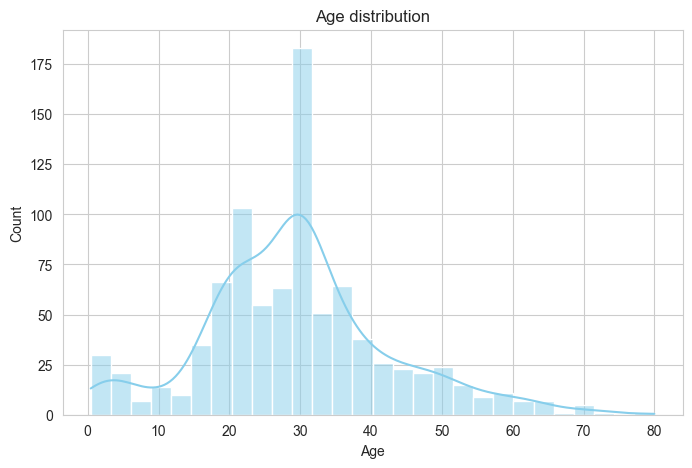

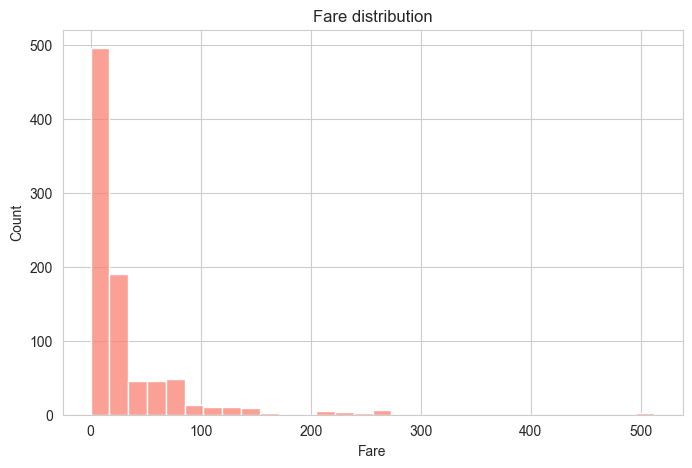

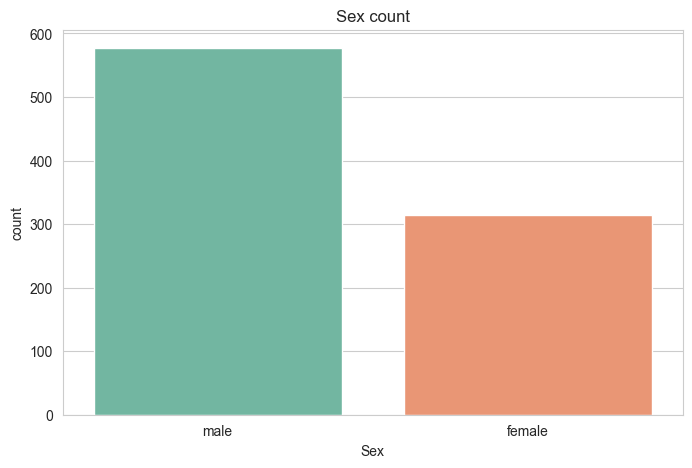

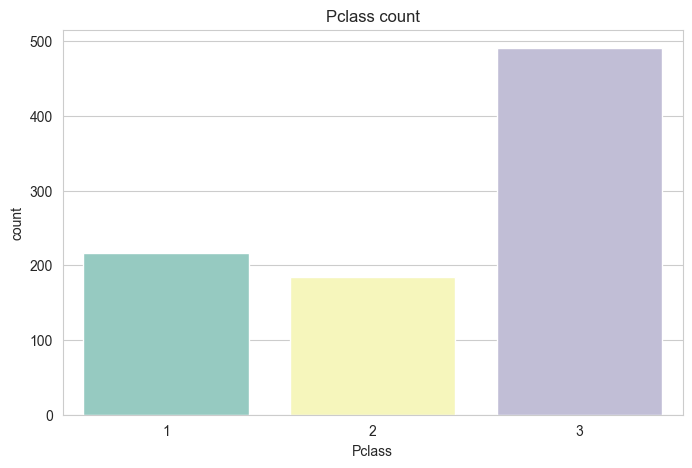

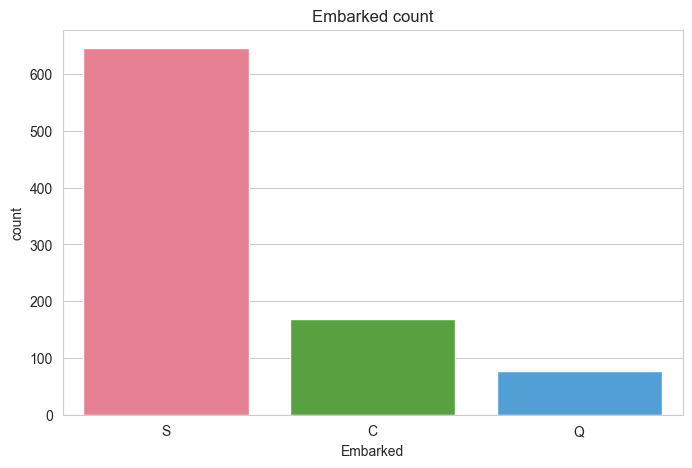

In [12]:

plt.figure()
sns.histplot(df['Age'], kde=True, color="skyblue")
plt.title('Age distribution')
plt.show()

plt.figure()
sns.histplot(df['Fare'], bins=30, color="salmon")
plt.title('Fare distribution')
plt.show()

plt.figure()
sns.countplot(x='Sex', hue='Sex', data=df, palette="Set2", legend=False)
plt.title('Sex count')
plt.show()

plt.figure()
sns.countplot(x='Pclass', hue='Pclass', data=df, palette="Set3", legend=False)
plt.title('Pclass count')
plt.show()

plt.figure()
sns.countplot(x='Embarked', hue='Embarked', data=df, palette="husl", legend=False)
plt.title('Embarked count')
plt.show()


# Step 6: Bivariate plots (clean, no warnings)

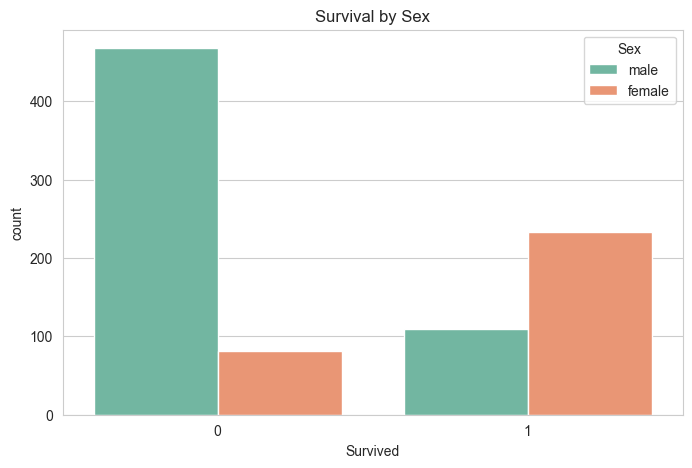

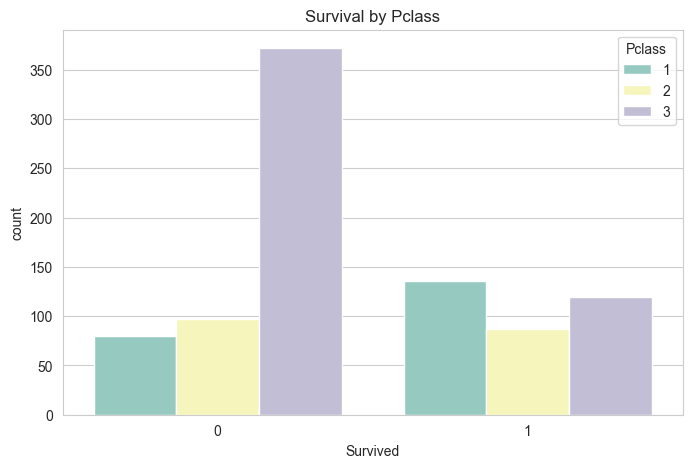

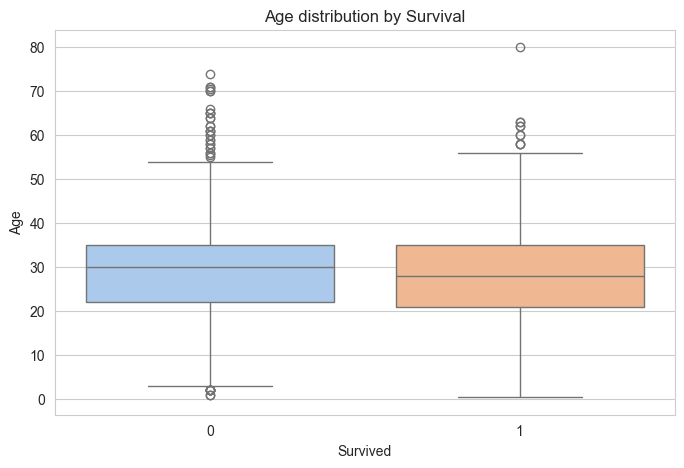

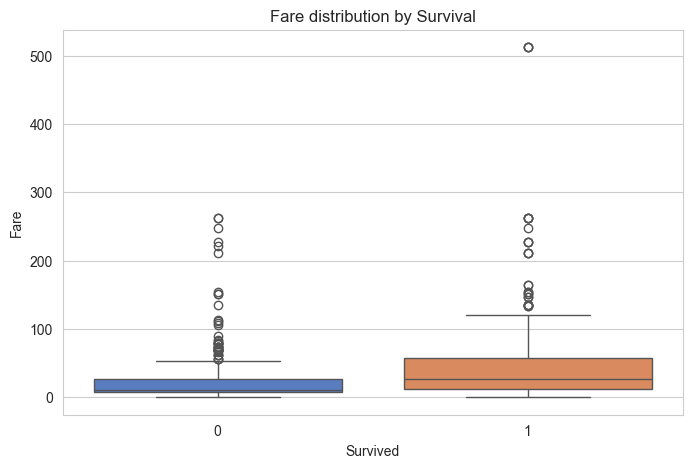

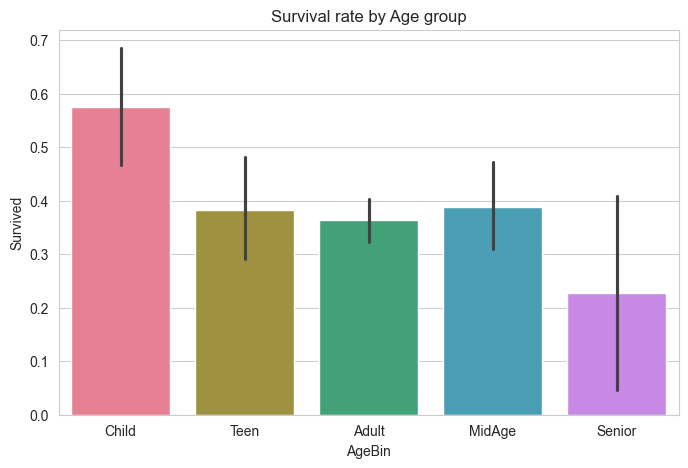

In [6]:
# Survival by Sex
plt.figure()
sns.countplot(x='Survived', hue='Sex', data=df, palette="Set2")
plt.title('Survival by Sex')
plt.show()

# Survival by Pclass
plt.figure()
sns.countplot(x='Survived', hue='Pclass', data=df, palette="Set3")
plt.title('Survival by Pclass')
plt.show()

# Age distribution by Survival
plt.figure()
sns.boxplot(x='Survived', y='Age', hue='Survived', data=df, palette="pastel", legend=False)
plt.title('Age distribution by Survival')
plt.show()

# Fare distribution by Survival
plt.figure()
sns.boxplot(x='Survived', y='Fare', hue='Survived', data=df, palette="muted", legend=False)
plt.title('Fare distribution by Survival')
plt.show()

# Ensure AgeBin exists (safe check)
if 'AgeBin' not in df.columns:
    df['AgeBin'] = pd.cut(
        df['Age'],
        bins=[0,12,20,40,60,120],
        labels=['Child','Teen','Adult','MidAge','Senior']
    )

# Survival rate by Age group
plt.figure()
sns.barplot(
    x='AgeBin', y='Survived',
    hue='AgeBin', data=df,
    order=['Child','Teen','Adult','MidAge','Senior'],
    palette="husl", legend=False
)
plt.title('Survival rate by Age group')
plt.show()

# Step 7: correlation heatmap (robust version)

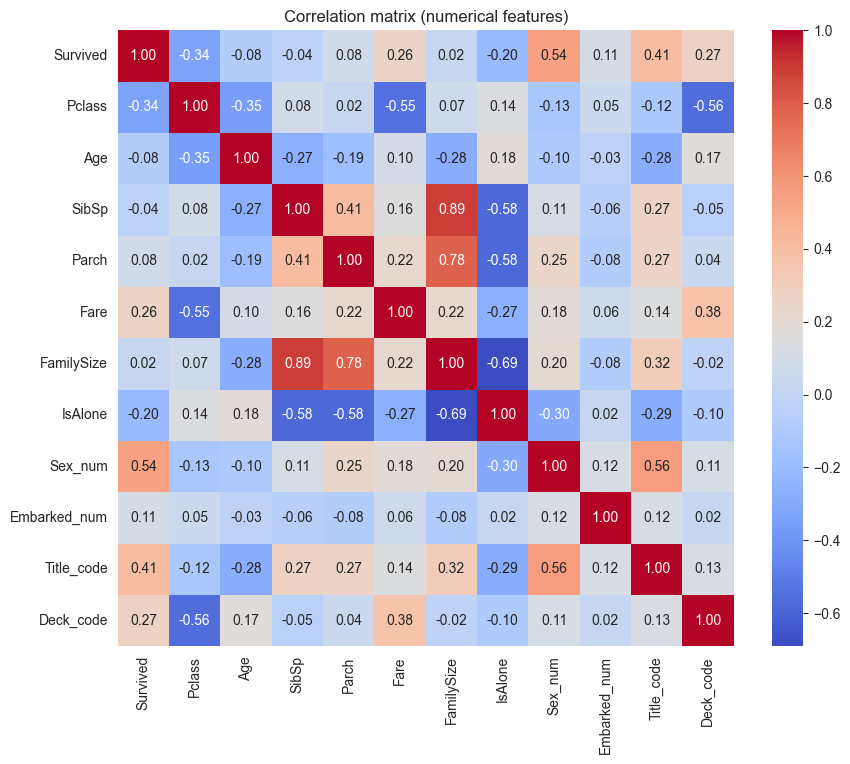

In [13]:
# Candidate numerical features
num_cols = [
    'Survived','Pclass','Age','SibSp','Parch','Fare',
    'FamilySize','IsAlone','Sex_num','Embarked_num','Title_code','Deck_code'
]

# Keep only the ones that exist
num_cols = [c for c in num_cols if c in df.columns]

corr = df[num_cols].corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar=True)
plt.title('Correlation matrix (numerical features)')
plt.show()


# Step 8: Group survival stats

In [14]:
print("Overall survival rate: {:.2%}".format(df['Survived'].mean()))

print("\nSurvival rate by sex:")
print(df.groupby('Sex')['Survived'].mean().sort_values(ascending=False))

print("\nSurvival rate by Pclass:")
print(df.groupby('Pclass')['Survived'].mean())

# Survival rate by Title (only if Title exists)
if 'Title' in df.columns:
    print("\nSurvival rate by Title (descending):")
    print(df.groupby('Title')['Survived'].mean().sort_values(ascending=False))
else:
    print("\n⚠️ Column 'Title' not found. Re-run Chunk 3 to generate it.")

# Top combinations
surv_by = df.groupby(['Pclass','Sex'])['Survived'].mean().unstack()
display(surv_by)


Overall survival rate: 38.38%

Survival rate by sex:
Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64

Survival rate by Pclass:
Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64

Survival rate by Title (descending):
Title
the Countess    1.000000
Mrs             0.793651
Miss            0.702703
Master          0.575000
Other           0.318182
Mr              0.156673
Name: Survived, dtype: float64


Sex,female,male
Pclass,,
1,0.968085,0.368852
2,0.921053,0.157407
3,0.500000,0.135447


# Step 9: Save cleaned  dataset


In [15]:
df.to_csv("titanic_cleaned.csv", index=False)
print("Saved titanic_cleaned.csv (contains engineered columns).")


Saved titanic_cleaned.csv (contains engineered columns).
